In [1]:
%matplotlib inline
import numpy as np
import sklearn
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import math
import itertools
import time

import sklearn.neighbors
from sklearn.neighbors import (
    KernelDensity,
    KDTree,
)
from sklearn.preprocessing import (
    RobustScaler
)
import sklearn.decomposition
import sklearn.covariance
import sklearn.mixture
import sklearn.svm

In [2]:
def smart_bin(s1, s2):
    extent = (
        np.percentile(s1, 1), 
        np.percentile(s1, 99), 
        np.percentile(s2, 1),
        np.percentile(s2, 99),
    )
    plt.hexbin(s1, s2, extent=extent, gridsize=40, linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='plasma')

In [3]:
df = pd.read_csv(
    "../rawdata/shuttle.csv",
    header=None,
    delim_whitespace=True
).rename(
    columns={9: "label"}
)

In [4]:
df.to_csv("../../data/shuttle.csv", index=False)

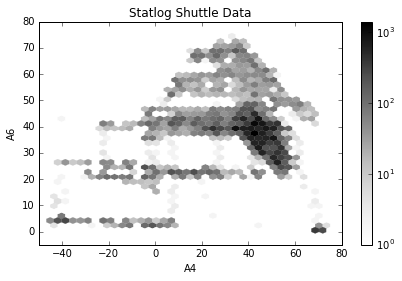

In [5]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(
    df[4], df[6], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.colorbar()
plt.xlabel("A4")
plt.ylabel("A6")
plt.title("Statlog Shuttle Data")
fig.tight_layout()
fig.savefig("shuttle46.pdf")

0,0


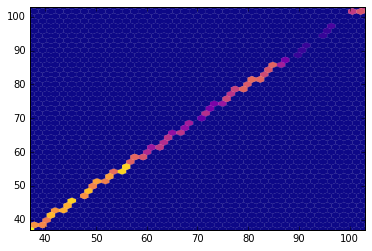

0,1


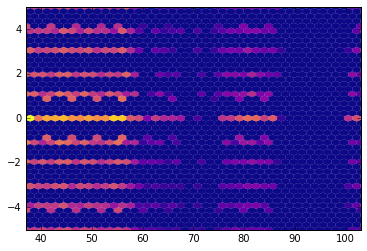

0,2


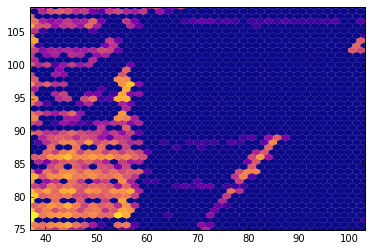

0,3


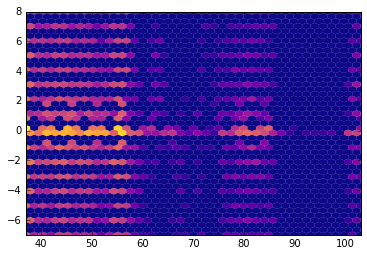

0,4


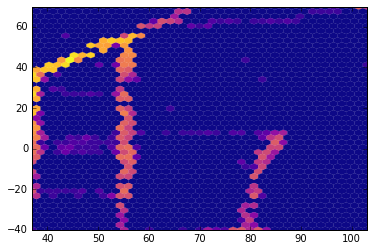

0,5


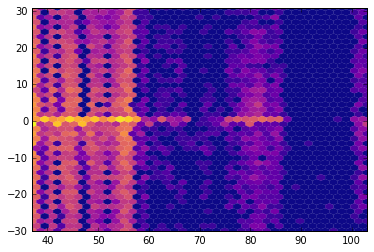

0,6


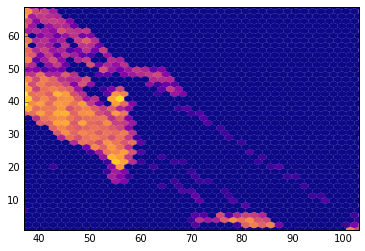

0,7


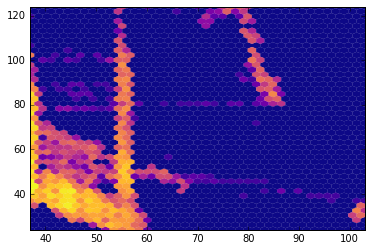

0,8


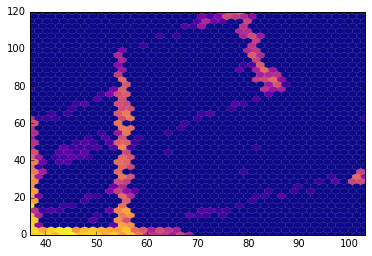

1,1


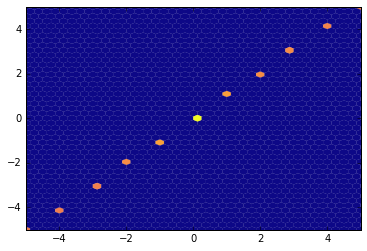

1,2


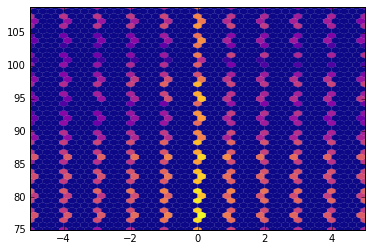

1,3


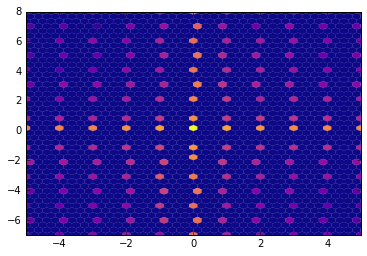

1,4


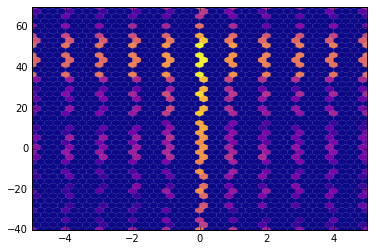

1,5


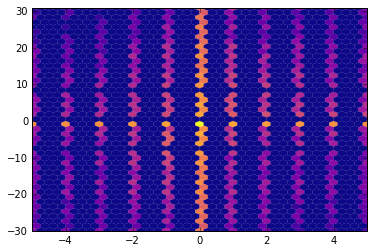

1,6


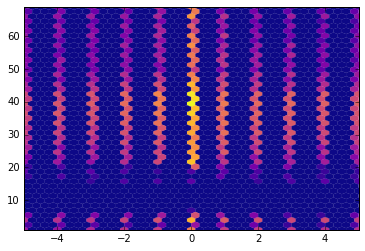

1,7


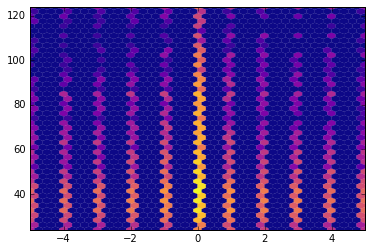

1,8


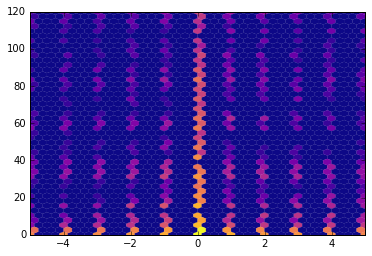

2,2


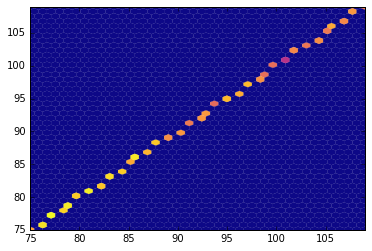

2,3


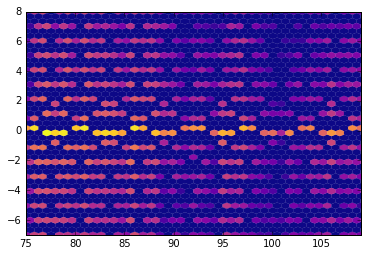

2,4


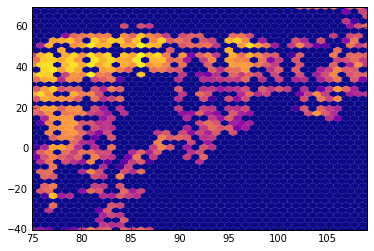

2,5


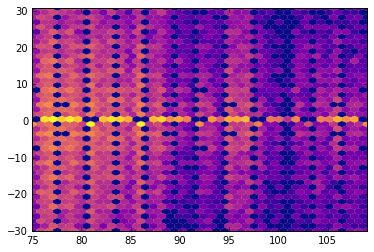

2,6


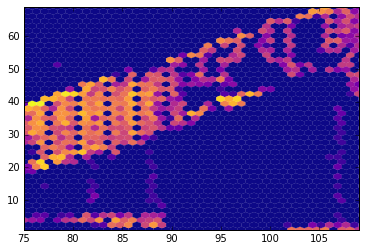

2,7


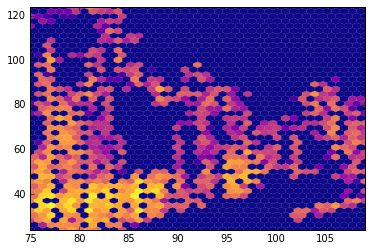

2,8


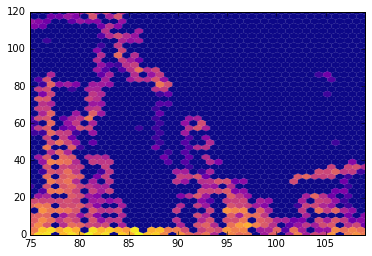

3,3


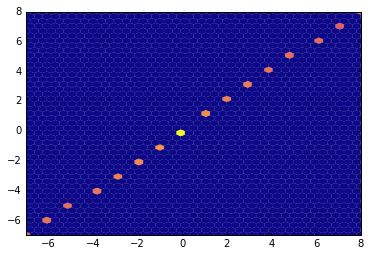

3,4


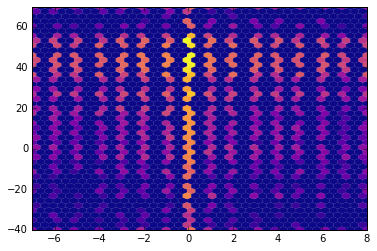

3,5


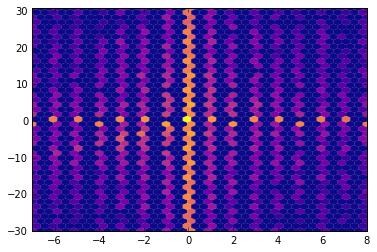

3,6


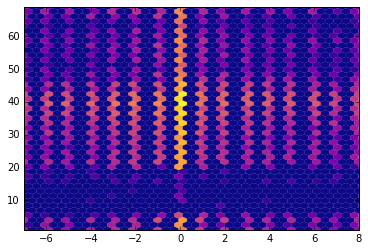

3,7


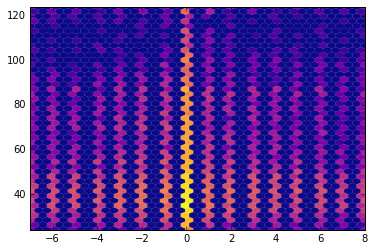

3,8


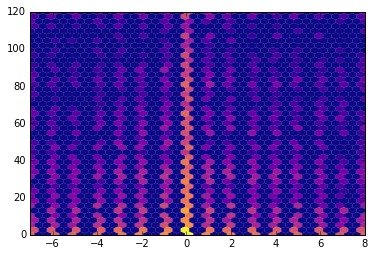

4,4


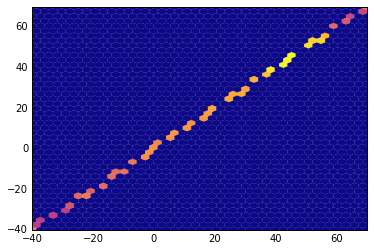

4,5


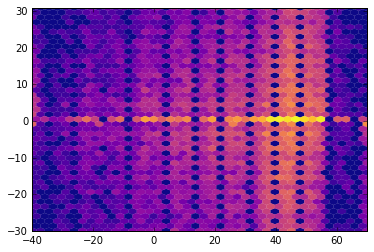

4,6


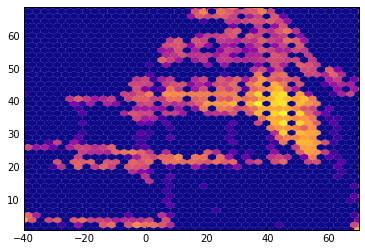

4,7


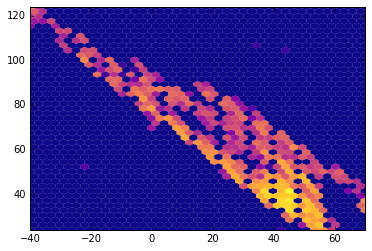

4,8


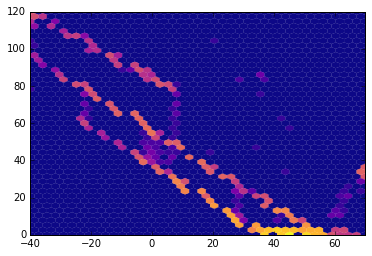

5,5


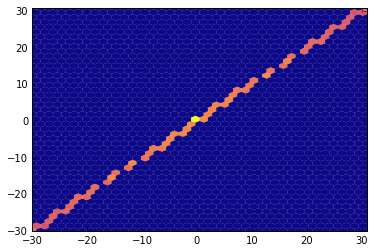

5,6


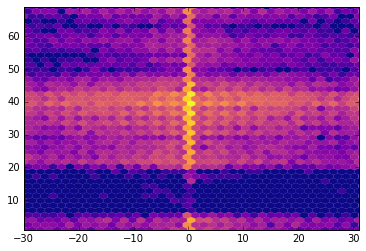

5,7


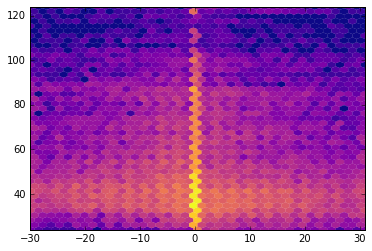

5,8


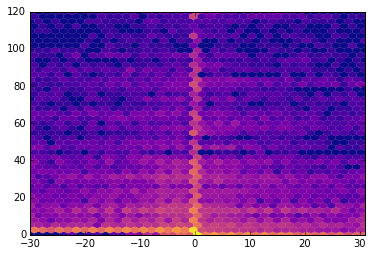

6,6


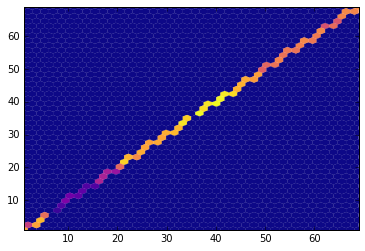

6,7


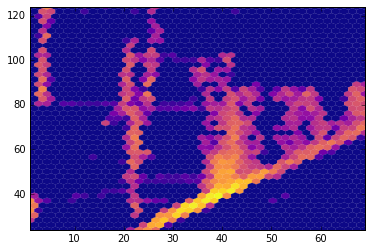

6,8


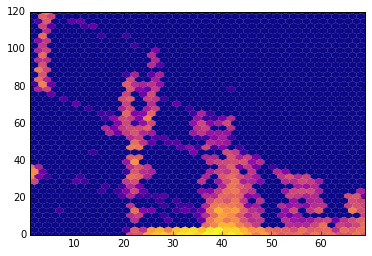

7,7


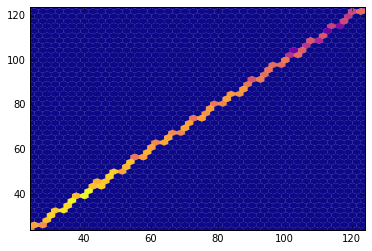

7,8


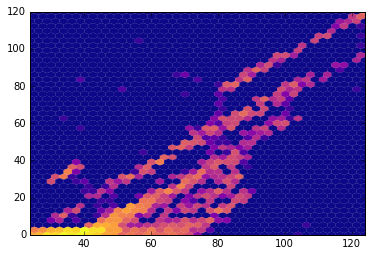

8,8


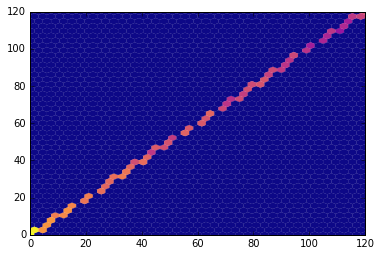

In [6]:
for i in range(9):
    for j in range(i,9):
        print("{},{}".format(i,j))
        plt.figure()
        smart_bin(df[i],df[j])
        plt.show()

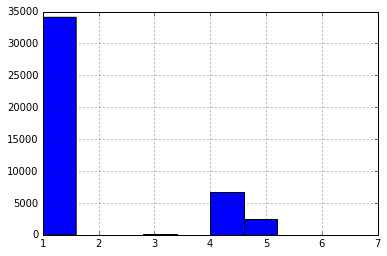

In [45]:
df.label.hist()

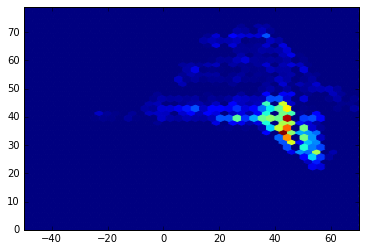

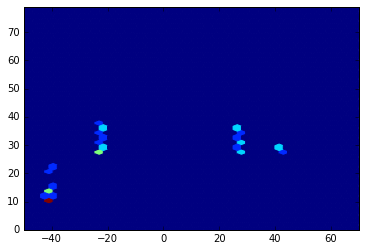

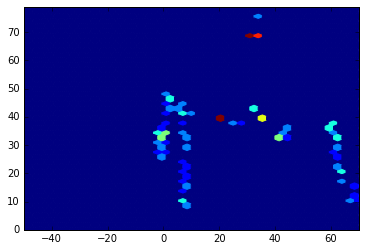

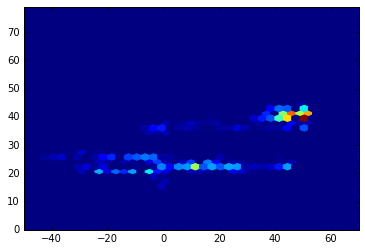

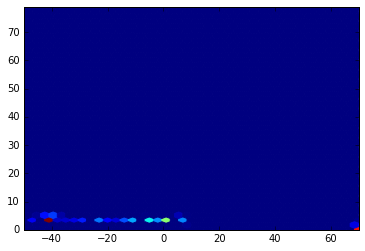

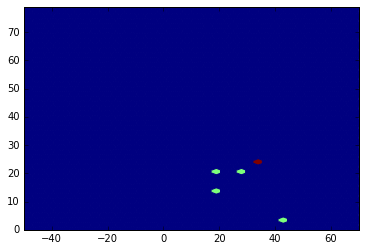

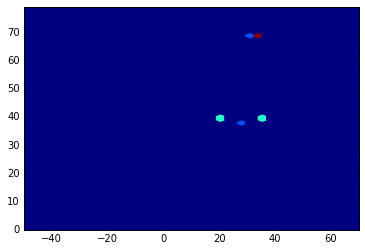

In [173]:
for l in range(1,8):
    plt.figure()
    plt.hexbin(
        df[df.label==l].values[:,4],
        df[df.label==l].values[:,6],
        gridsize=40,
        extent=(-50,70,0,79)
    )
    plt.show()

# Outliers

In [10]:
inlier_l = (df.label == 5) | (df.label == 4) | (df.label == 1)
outlier_l = ~inlier_l
ivalues = df[inlier_l].values[:,:9]
ovalues = df[outlier_l].values[:,:9]
values = df.values[:,:9]

In [5]:
sum(outlier_l)

186

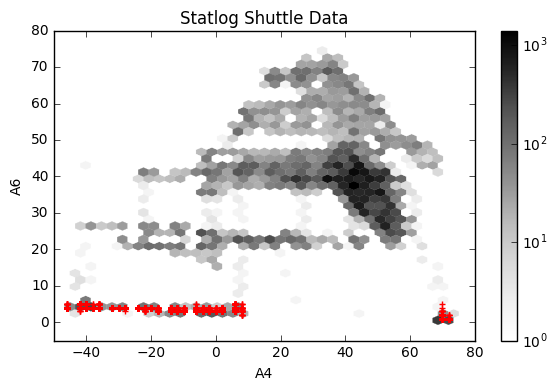

In [7]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(
    df[4], df[6], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.colorbar()
plt.scatter(
    df[df.label == 5][[4]], df[df.label == 5][[6]], 
    marker='+', c='r')
plt.xlim(-50,80)
plt.ylim(-5,80)
plt.xlabel("A4")
plt.ylabel("A6")
plt.title("Statlog Shuttle Data")
fig.tight_layout()

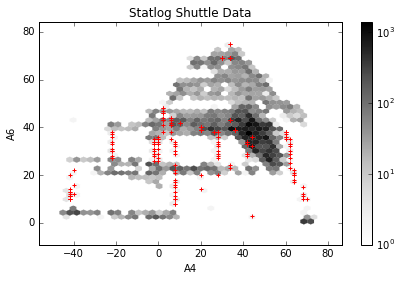

In [14]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(
    df[4], df[6], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.colorbar()
plt.xlabel("A4")
plt.ylabel("A6")
plt.title("Statlog Shuttle Data")
fig.tight_layout()
plt.scatter(df[outlier_l][[4]], df[outlier_l][[6]], marker='+', c='r')
fig.savefig("shuttle46out.pdf")

In [4]:
def estimate_kde_bw(data):
    q3 = np.percentile(data, 75, axis=0)
    q1 = np.percentile(data, 25, axis=0)
    iqr = q3 - q1
    bw = iqr * (data.shape[0])**(-1.0/(data.shape[1]+4))
    return bw

In [5]:
bw = estimate_kde_bw(values)
norm_data = values / bw
bw

NameError: name 'values' is not defined

In [20]:
wdata = norm_data[:,[4,6]]

In [18]:
def eval_scores(scores, true_outliers):
    cutoff = np.percentile(scores, 99)
    est_outliers = scores > cutoff
    both = sum(np.logical_and(est_outliers,true_outliers))
    predict = sum(est_outliers)
    actual = sum(true_outliers)
    print("{}/{},{}".format(both, predict, actual))
    return est_outliers

# covar

In [146]:
%%timeit -n 10
mcd = sklearn.covariance.EmpiricalCovariance(
)
mcd.fit(wdata)
mcd_scores = mcd.mahalanobis(wdata)
eval_scores(mcd_scores, outlier_l)

0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
0/298,186
10 loops, best of 3: 184 ms per loop


# MCD

In [143]:
t=time.time()
mcd = sklearn.covariance.MinCovDet(
    random_state=0
)
mcd.fit(wdata)
mcd_scores = mcd.mahalanobis(wdata)
print(time.time() - t)
eval_scores(mcd_scores, outlier_l)

6.451020956039429
0/286,186


array([False, False, False, ..., False, False, False], dtype=bool)

# knn

In [140]:
# lots of overlapping points

In [24]:
def calc_knn(k, data, outlier_l):
    tree = KDTree(data)
    distances, _ = tree.query(data, k=k)
    knndistances = distances[:,k-1]
    eval_scores(knndistances, outlier_l)

In [151]:
t = time.time()
calc_knn(4, wdata, outlier_l)
print(time.time() - t)

109/227,186
0.5886249542236328


In [27]:
for k in range(1,11):
    print("k: {}".format(k))
    calc_knn(k, wdata, outlier_l)

k: 1
0/0,186
k: 2
68/102,186
k: 3
99/176,186
k: 4
109/227,186
k: 5
109/291,186
k: 6
109/376,186
k: 7
109/430,186
k: 8
95/147,186
k: 9
95/147,186
k: 10
95/158,186


# gmm

In [31]:
def calc_gmm(k, data, outlier_l):
    gmm = sklearn.mixture.GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=0,
    )
    gmm.fit(data)
    gmm_scores = gmm.score_samples(data)
    eval_scores(-gmm_scores, outlier_l)

In [34]:
for k in range(1,40,5):
    print("k: {}".format(k))
    calc_gmm(k, wdata, outlier_l)

k: 1
0/298,186
k: 6
72/429,186
k: 11
78/399,186
k: 16
79/433,186
k: 21
85/432,186
k: 26
92/421,186
k: 31
85/427,186
k: 36
98/430,186


In [149]:
t = time.time()
calc_gmm(36, wdata, outlier_l)
print(time.time()- t)

98/430,186
15.303756952285767


# One Class SVM

In [98]:
def calc_svm(nu, gamma, data, outlier_l):
    svm = sklearn.svm.OneClassSVM(nu=nu,kernel="rbf",gamma=gamma)
    svm.fit(data)
    scores = svm.decision_function(data)
    eval_scores(-scores.ravel(), outlier_l)

In [150]:
t = time.time()
calc_svm(.03, 4.0, wdata, outlier_l)
print(time.time()- t)

117/429,186
9.20127010345459


In [111]:
svm = sklearn.svm.OneClassSVM(nu=.03,kernel="rbf",gamma=3.0)
svm.fit(wdata)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=3.0, kernel='rbf',
      max_iter=-1, nu=0.03, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

(0, 15)

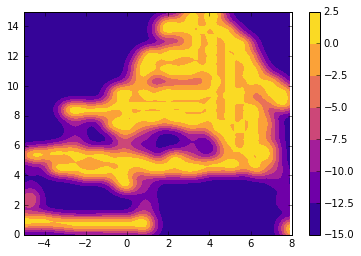

In [113]:
x = np.arange(-5,8,.1)
y = np.arange(0,15,.1)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=svm.decision_function([[X[i,j],Y[i,j]]])[0]
plt.figure()
plt.contourf(
    X,Y,Z,cmap='plasma',
    extent=(-5,8,0,15))
plt.colorbar()
plt.xlim(-5,8)
plt.ylim(0,15)

# DBScan (too many parameters)

In [89]:
def calc_db(eps, n, data, outlier_l):
    dbs = sklearn.cluster.DBSCAN(
        eps=eps,
        min_samples=n
    )
    clusters = dbs.fit_predict(data)
    outliers = (clusters == -1)
    both = sum(np.logical_and(outliers, outlier_l))
    predict = sum(outliers)
    actual = sum(outlier_l)
    print("{}/{},{}".format(both, predict, actual))

In [94]:
calc_db(.1, 5, wdata, outlier_l)

109/291,186


# KDE

In [152]:
def calc_kde(bw, data, outlier_l):
    tol = .1
    kde = KernelDensity(
        bandwidth=bw,
        kernel='gaussian',
        algorithm='kd_tree',
        rtol=tol,
    )
    kde.fit(data)
    kde_scores = kde.score_samples(data)
    eval_scores(-kde_scores, outlier_l)

In [63]:
for bw in [.05, .1, .2, .5, 1.0, 2.0, 10.0]:
    print("bw: {}".format(bw))
    calc_kde(bw, wdata, outlier_l)

bw: 0.05
109/430,186
bw: 0.1
107/430,186
bw: 0.2
96/425,186
bw: 0.5
68/428,186
bw: 1.0
38/404,186
bw: 2.0
2/316,186
bw: 10.0
0/298,186


In [153]:
t = time.time()
calc_kde(0.05, wdata, outlier_l)
print(time.time() - t)

109/430,186
1.723249912261963


In [73]:
kde = KernelDensity(
    bandwidth=0.05,
    kernel='gaussian',
    algorithm='kd_tree',
    rtol=.1,
)
kde.fit(wdata)

KernelDensity(algorithm='kd_tree', atol=0, bandwidth=0.05, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.1)

(0, 15)

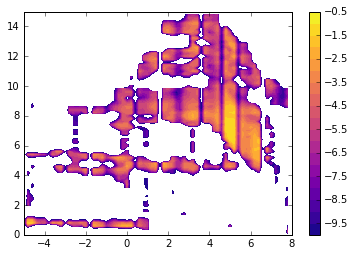

In [88]:
x = np.arange(-5,8,.2)
y = np.arange(0,15,.2)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]])[0]
plt.figure()
plt.contourf(
    X,Y,Z,
    levels=np.arange(-10,0,.5),cmap='plasma',
    extent=(-5,8,0,15))
plt.colorbar()
plt.xlim(-5,8)
plt.ylim(0,15)